In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from random import randrange
import cv2

In [2]:
classes = {'Black-grass': 0,
         'Charlock': 1,
         'Cleavers': 2,
         'Common Chickweed': 3,
         'Common wheat': 4,
         'Fat Hen': 5,
         'Loose Silky-bent': 6,
         'Maize': 7,
         'Scentless Mayweed': 8,
         'Shepherds Purse': 9,
         'Small-flowered Cranesbill': 10,
         'Sugar beet': 11}
image_size = 256
target_size = (256, 256)
batch_size = 32

In [18]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
training_img_list = pd.DataFrame(columns=['filename','class'])
pathToTrainData="/content/gdrive/My Drive/GL_Assignments/Computer Vision/Data/train/"

for dirname, _, filenames in os.walk(pathToTrainData):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        class_label = dirname.split('/')[-1]
        training_img_list = training_img_list.append({'filename':path , 'class':class_label}, ignore_index = True)

In [5]:
training_img_list = sklearn.utils.shuffle(training_img_list)
training_img_list.head(10)

,filename,class
1345,/content/gdrive/My Drive/GL_Assignments/Comput...,Scentless Mayweed
4057,/content/gdrive/My Drive/GL_Assignments/Comput...,Cleavers
1003,/content/gdrive/My Drive/GL_Assignments/Comput...,Scentless Mayweed
3881,/content/gdrive/My Drive/GL_Assignments/Comput...,Cleavers
3793,/content/gdrive/My Drive/GL_Assignments/Comput...,Fat Hen
4285,/content/gdrive/My Drive/GL_Assignments/Comput...,Black-grass
3023,/content/gdrive/My Drive/GL_Assignments/Comput...,Loose Silky-bent
3013,/content/gdrive/My Drive/GL_Assignments/Comput...,Loose Silky-bent
3910,/content/gdrive/My Drive/GL_Assignments/Comput...,Cleavers
4411,/content/gdrive/My Drive/GL_Assignments/Comput...,Charlock


In [6]:
idg_sample = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True
                    )
sample_data = idg_sample.flow_from_directory("/content/gdrive/My Drive/GL_Assignments/Computer Vision/Data/train/",
                                                    target_size=target_size,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    seed=1,
                                                    classes = classes
                                                )

Found 4767 images belonging to 12 classes.


In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_unique_grid(image_gen, figsize=(10,10)):
    dist_classes = [image_gen.classes.tolist().index(x) for x in set(image_gen.classes.tolist())]
    title_list = [image_gen.classes.tolist()[i] for i in dist_classes]
    im_set = [image_gen[i//32][0][i%32] for i in dist_classes]
    fig = plt.figure(None, (10,10),frameon=False)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(3, 4),  
                     axes_pad=0.2, 
                     share_all=True,
                     )
    for i in range(12):
        ax = grid[i]
        ax.imshow(im_set[i],cmap='Greys_r')
        ax.set_title(title_list[i])
        ax.axis('off')

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

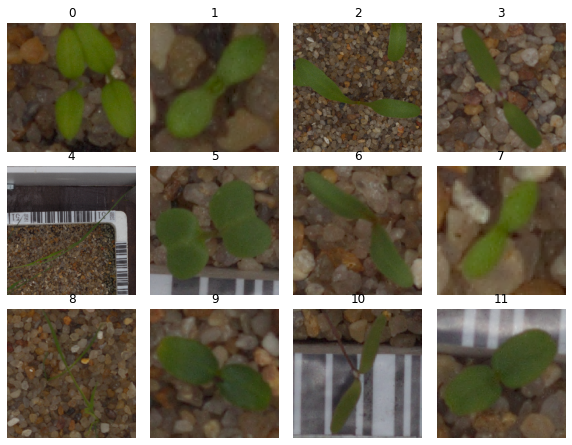

In [8]:
show_unique_grid(sample_data)
sample_data.class_indices

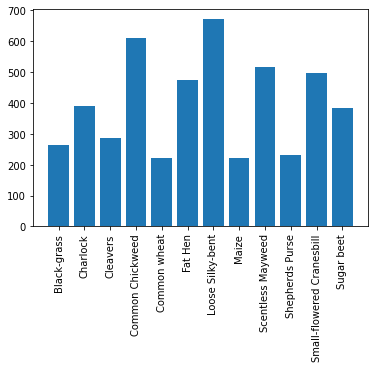

In [9]:
unique, counts = np.unique(sample_data.classes, return_counts=True)
dict1 = dict(zip(sample_data.class_indices, counts))

keys = dict1.keys()
values = dict1.values()

plt.xticks(rotation='vertical')
bar = plt.bar(keys, values)

Image Classification using CNN

In [10]:
def get_model():
    model = tf.keras.models.Sequential() #1
    model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,))) #2
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #3
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #4
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #5
    model.add(tf.keras.layers.BatchNormalization()) #6
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu')) #7
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #8
    model.add(tf.keras.layers.BatchNormalization()) #9
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #10
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #11
    model.add(tf.keras.layers.BatchNormalization()) #12
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #13
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #14
    model.add(tf.keras.layers.GlobalMaxPool2D()) #15
    model.add(tf.keras.layers.Flatten()) #16 
    model.add(tf.keras.layers.Dense(128, activation='relu')) #17
    model.add(tf.keras.layers.Dropout(0.2)) #18
    model.add(tf.keras.layers.Dense(64, activation='relu')) #19
    model.add(tf.keras.layers.BatchNormalization()) #20
    model.add(tf.keras.layers.Dense(12, activation='softmax')) #21
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        2

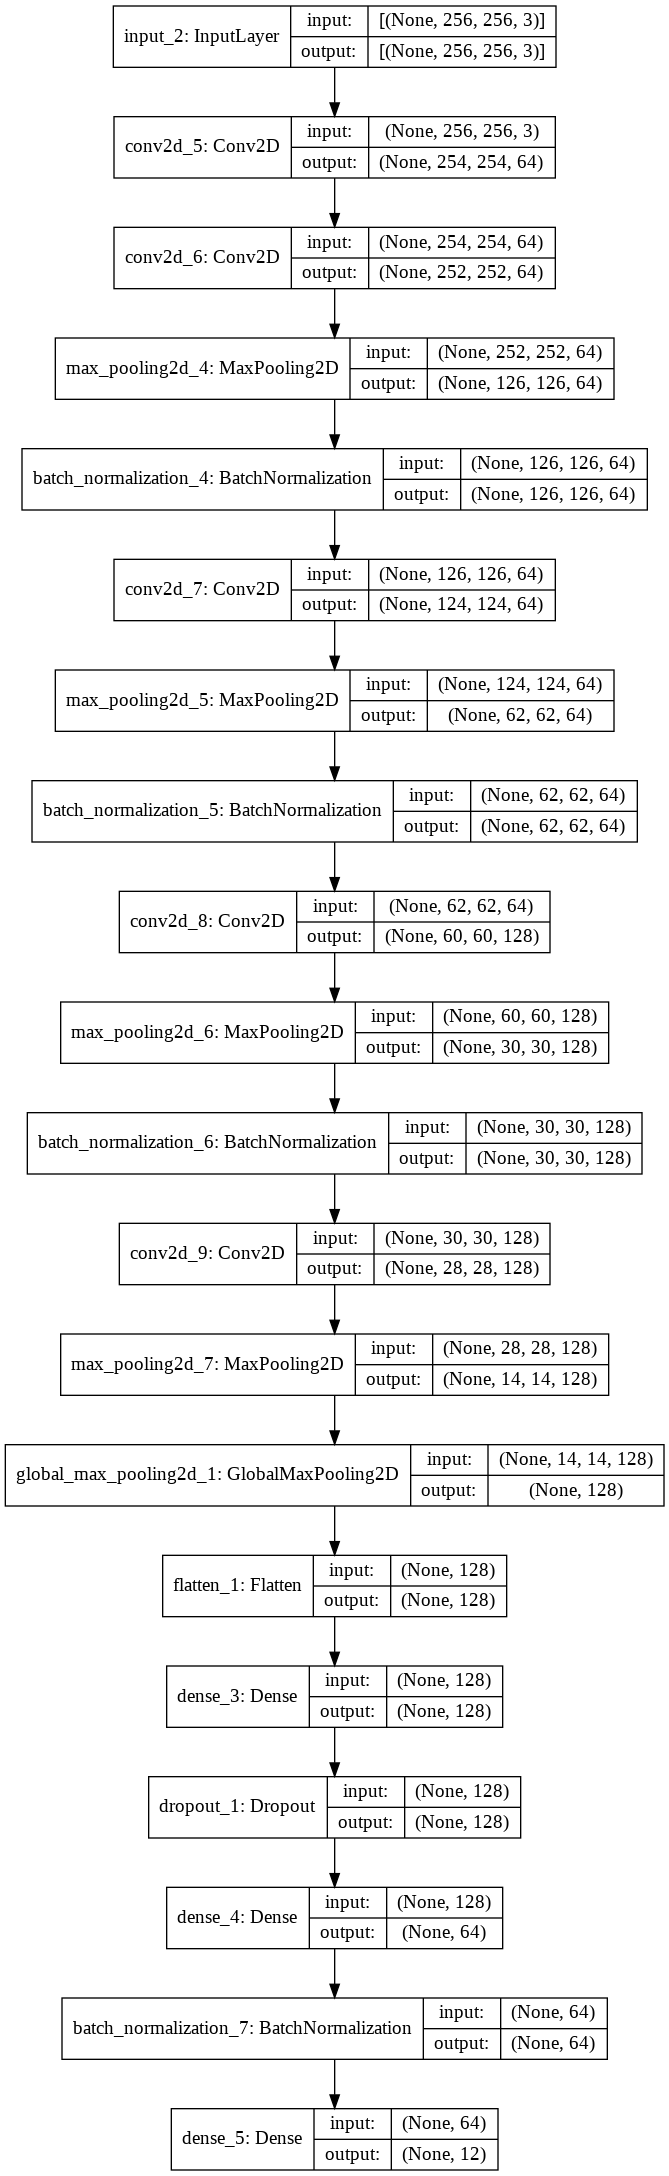

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(get_model(), show_shapes=True, show_layer_names=True)

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


kfold = KFold(n_splits=5, shuffle=True)
fold = 1
accuracies = []
rand_num = randrange(100000)
for train, test in kfold.split(training_img_list):
    model = get_model()
    idg = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
    #Actual Training data for the model
    train_gen = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='training',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        shuffle=True,
                                        classes=classes
                                        )
    #Validation set for training the model, so the checkpoint can track the best model with max val accuracy
    val_gen   = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='validation',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        classes=classes
                                        )
    

    model_name = 'plant_classifier_'+str(rand_num)+'_fold_no_'+str(fold)+'.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1
                                                    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)
    history = model.fit(train_gen,
                        epochs=20,
                        validation_data=val_gen,
                        callbacks = [checkpoint, es],
                        verbose = 1
                        )
    # Testing for the fold
    idg2 = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True
                       )
    test_gen = idg2.flow_from_dataframe(training_img_list.iloc[test,:],
                                        x_col="filename",
                                        y_col="class",
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        classes=classes,
                                        shuffle=False
                                        )
    model.load_weights('./'+model_name)
    predictions = model.predict(test_gen, steps=test_gen.samples)
    y_pred = []
    for i in range(0, predictions.shape[0]):
      y_class = predictions[i, :].argmax(axis=-1)
      y_pred.append(y_class)
    accuracies.append(accuracy_score(test_gen.classes, y_pred))
    print('Accuracy for the fold ',fold, ': ', accuracies[fold-1])
    fold += 1

Found 3051 validated image filenames belonging to 12 classes.
Found 762 validated image filenames belonging to 12 classes.
Epoch 1/20
96/96 [==============================] - 872s 9s/step - loss: 2.5439 - accuracy: 0.1708 - val_loss: 2.5745 - val_accuracy: 0.0958

Epoch 00001: val_accuracy improved from -inf to 0.09580, saving model to plant_classifier_4019_fold_no_1.h5
Epoch 2/20
96/96 [==============================] - 54s 565ms/step - loss: 1.6792 - accuracy: 0.4399 - val_loss: 3.1282 - val_accuracy: 0.1339

Epoch 00002: val_accuracy improved from 0.09580 to 0.13386, saving model to plant_classifier_4019_fold_no_1.h5
Epoch 3/20
96/96 [==============================] - 53s 546ms/step - loss: 1.2031 - accuracy: 0.6034 - val_loss: 3.3365 - val_accuracy: 0.1575

Epoch 00003: val_accuracy improved from 0.13386 to 0.15748, saving model to plant_classifier_4019_fold_no_1.h5
Epoch 4/20
96/96 [==============================] - 52s 540ms/step - loss: 0.9662 - accuracy: 0.6752 - val_loss: 4.63

In [14]:
print('5 fold accuracies= ', accuracies)
print('5 fold accuracy = ', np.mean(accuracies))

5 fold accuracies=  [0.8301886792452831, 0.8668763102725366, 0.863588667366212, 0.8772298006295908, 0.8226652675760755]
5 fold accuracy =  0.8521097450179397


In [19]:
predict_img_list = pd.DataFrame(columns=['filename'])
pathToPredictData="/content/gdrive/My Drive/GL_Assignments/Computer Vision/Data/Seedling - Prediction/"

for dirname, _, filenames in os.walk(pathToPredictData):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        #print(path)
        class_label = dirname.split('/')[-1]
        #print(class_label)
        predict_img_list = predict_img_list.append({'filename':path , 'class':class_label}, ignore_index = True)

predict_idg_sample = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True
                    )
predict_data = predict_idg_sample.flow_from_directory("/content/gdrive/My Drive/GL_Assignments/Computer Vision/Data/Seedling - Prediction",
                                                    target_size=target_size,
                                                    #subset='training',
                                                    class_mode=None,
                                                    batch_size=64,
                                                    shuffle=False,
                                                    seed=1,
                                                    classes = class_label
                                                )

Found 1 images belonging to 1 classes.


In [20]:
predictions = model.predict(predict_data, steps=predict_data.samples)
y_pred = []
for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  y_pred.append(y_class)
  print(y_class)

7


So, this is predicting this as a Maize Seedling

Image Classification using SVM

In [9]:
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model

In [13]:
model = tf.keras.models.Sequential() #1
model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,))) #2
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #3
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #4
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #5
model.add(tf.keras.layers.BatchNormalization()) #6
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu')) #7
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #8
model.add(tf.keras.layers.BatchNormalization()) #9
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #10
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #11
model.add(tf.keras.layers.BatchNormalization()) #12
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #13
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #14
model.add(tf.keras.layers.GlobalMaxPool2D()) #15
model.add(tf.keras.layers.Flatten()) #16 
model.add(tf.keras.layers.Dense(128, activation='relu')) #17
model.add(tf.keras.layers.Dropout(0.2)) #18
model.add(tf.keras.layers.Dense(64, activation='relu', name='dense_last')) #19
model.add(tf.keras.layers.BatchNormalization()) #20
model.add(tf.keras.layers.Dense(12, activation='softmax')) #21
#model.add(tf.keras.layers.Dense(12, kernel_regularizer= l2(0.01), activation='softmax')) #21

kfold = KFold(n_splits=5, shuffle=True)
fold = 1
accuracies = []
for train, test in kfold.split(training_img_list):

    idg = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
    #Actual Training data for the model
    train_gen = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='training',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        shuffle=True,
                                        classes=classes
                                        )
    #Validation set for training the model, so the checkpoint can track the best model with max val accuracy
    val_gen   = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='validation',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        classes=classes
                                        )

  #model.get_layer(index=16)
    model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_last').output)
    feat_train = model_feat.predict(train_gen)
    feat_test = model_feat.predict(val_gen)

    svm = SVC(kernel='rbf')
    svm.fit(feat_train,train_gen.classes)

    accuracy = svm.score(feat_test,val_gen.classes)
    accuracies.append(accuracy)
    print('Accuracy for the fold ',fold, ': ', accuracies[fold-1])
    fold += 1



Found 3051 validated image filenames belonging to 12 classes.
Found 762 validated image filenames belonging to 12 classes.
Accuracy for the fold  1 :  0.14829396325459318
Found 3051 validated image filenames belonging to 12 classes.
Found 762 validated image filenames belonging to 12 classes.
Accuracy for the fold  2 :  0.13910761154855644
Found 3052 validated image filenames belonging to 12 classes.
Found 762 validated image filenames belonging to 12 classes.
Accuracy for the fold  3 :  0.1272965879265092
Found 3052 validated image filenames belonging to 12 classes.
Found 762 validated image filenames belonging to 12 classes.
Accuracy for the fold  4 :  0.14698162729658792
Found 3052 validated image filenames belonging to 12 classes.
Found 762 validated image filenames belonging to 12 classes.
Accuracy for the fold  5 :  0.1377952755905512


In [14]:
print('5 fold accuracies= ', accuracies)
print('5 fold accuracy = ', np.mean(accuracies))

5 fold accuracies=  [0.14829396325459318, 0.13910761154855644, 0.1272965879265092, 0.14698162729658792, 0.1377952755905512]
5 fold accuracy =  0.13989501312335959


Image Classification using Fully Connected Neural Network

In [ ]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_model_nn():
    model = tf.keras.models.Sequential() #1
    model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,))) #2
    # model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #3
    # model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #4
    # model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #5
    # model.add(tf.keras.layers.BatchNormalization()) #6
    # model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu')) #7
    # model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #8
    # model.add(tf.keras.layers.BatchNormalization()) #9
    # model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #10
    # model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #11
    # model.add(tf.keras.layers.BatchNormalization()) #12
    # model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #13
    # model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #14
    # model.add(tf.keras.layers.GlobalMaxPool2D()) #15
    model.add(tf.keras.layers.Flatten()) #16 
    model.add(tf.keras.layers.Dense(1000, activation='relu', kernel_initializer='he_normal')) #17a
    model.add(tf.keras.layers.Dropout(0.2)) #18
    model.add(tf.keras.layers.Dense(256, activation='relu')) #17b
    model.add(tf.keras.layers.Dense(128, activation='relu')) #17c
    model.add(tf.keras.layers.Dense(64, activation='relu')) #19
    model.add(tf.keras.layers.BatchNormalization()) #20
    #model.add(tf.keras.layers.Dense(12, activation='softmax')) #21
    from tensorflow.keras.regularizers import l2
    model.add(tf.keras.layers.Dense(12, kernel_regularizer= l2(0.01), activation='softmax')) #21
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


kfold = KFold(n_splits=5, shuffle=True)
fold = 1
accuracies = []
rand_num = randrange(100000)
for train, test in kfold.split(training_img_list):
    model = get_model_nn()
    idg = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
    #Actual Training data for the model
    train_gen = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='training',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        shuffle=True,
                                        classes=classes
                                        )
    #Validation set for training the model, so the checkpoint can track the best model with max val accuracy
    val_gen   = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='validation',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        classes=classes
                                        )
    

    model_name = 'plant_classifier_'+str(rand_num)+'_fold_no_'+str(fold)+'.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1
                                                    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)
    history = model.fit(train_gen,
                        epochs=20,
                        validation_data=val_gen,
                        callbacks = [checkpoint, es],
                        verbose = 1
                        )
    # Testing for the fold
    idg2 = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True
                       )
    test_gen = idg2.flow_from_dataframe(training_img_list.iloc[test,:],
                                        x_col="filename",
                                        y_col="class",
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        classes=classes,
                                        shuffle=False
                                        )
    model.load_weights('./'+model_name)
    predictions = model.predict(test_gen, steps=test_gen.samples)
    y_pred = []
    for i in range(0, predictions.shape[0]):
      y_class = predictions[i, :].argmax(axis=-1)
      y_pred.append(y_class)
    accuracies.append(accuracy_score(test_gen.classes, y_pred))
    print('Accuracy for the fold ',fold, ': ', accuracies[fold-1])
    fold += 1

Found 3051 validated image filenames belonging to 12 classes.
Found 762 validated image filenames belonging to 12 classes.
Epoch 1/20
96/96 [==============================] - 1552s 16s/step - loss: 3.0238 - accuracy: 0.1003 - val_loss: 3.5787 - val_accuracy: 0.1234

Epoch 00001: val_accuracy improved from -inf to 0.12336, saving model to plant_classifier_50494_fold_no_1.h5
Epoch 2/20
96/96 [==============================] - 55s 569ms/step - loss: 2.8771 - accuracy: 0.1072 - val_loss: 4.3958 - val_accuracy: 0.0591

Epoch 00002: val_accuracy did not improve from 0.12336
Epoch 3/20
96/96 [==============================] - 49s 515ms/step - loss: 2.7552 - accuracy: 0.1236 - val_loss: 2.6636 - val_accuracy: 0.1575

Epoch 00003: val_accuracy improved from 0.12336 to 0.15748, saving model to plant_classifier_50494_fold_no_1.h5
Epoch 4/20
96/96 [==============================] - 51s 529ms/step - loss: 2.6993 - accuracy: 0.1301 - val_loss: 3.0618 - val_accuracy: 0.1063

Epoch 00004: val_accuracy

In [ ]:
print('5 fold accuracies= ', accuracies)
print('5 fold accuracy = ', np.mean(accuracies))

5 fold accuracies=  [0.3060796645702306, 0.3658280922431866, 0.3882476390346275, 0.3273871983210913, 0.34522560335781743]
5 fold accuracy =  0.34655363950539064


**Why CNN outperforms ANN and SVM**

CNNs can be thought of automatic feature extractors from the image. While a normal ANN with pixel vector is used, a lot of spatial interaction between pixels are lost. A CNN on the other hand, effectively uses adjacent pixel information to effectively downsample the image first by convolution and then uses a prediction layer at the end.

CNN's are really effective for image classification as the concept of dimensionality reduction suits the huge number of parameters in an image. 

For example: In this ANN, we have been able to use a 1000 neurons in the first layer to capture the features from an input size of 256x256. Having a layer with 256x256 neurons is not feasible as we will run out of memory. This is why we use convolutions to reduce the dimensionality while capturing critical spatial information about the image.